In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [45]:
import aesara.tensor as at
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import scipy.integrate as si
import seaborn as sns
import xarray as xr

sns.set_context('notebook')
sns.set_palette('husl')

What if we have a detection efficiency that varies as a function of inclination?  Let's suppose that it varies like a series of Legendre polynomials, e.g.:
$$
P_\mathrm{det}(x) = \frac{1}{2} \sum_{l=0}^N A_l P_l(x),
$$
where $x = \cos \iota$.  It is a bit hard to derive a general constraint on the $A_l$, but as long as $A_0 = 1$ and $|A_l| < 1/N$ we can ensure that the above sum (1) integrates to unity and (2) is everywhere positive.  In particular, suppose that our detection efficiency is given by 
$$
2 P_\mathrm{det}(x) = 1 + \frac{1}{2} \left( 3 x^2 - 1 \right),
$$
or $A_0 = 1$, $A_1 = 0$, and $A_2 = 1/2$ with $N = 2$.  This is plotted below:

Text(0, 0.5, '$p\\left( x \\mid \\mathrm{EMbright} \\right)$')

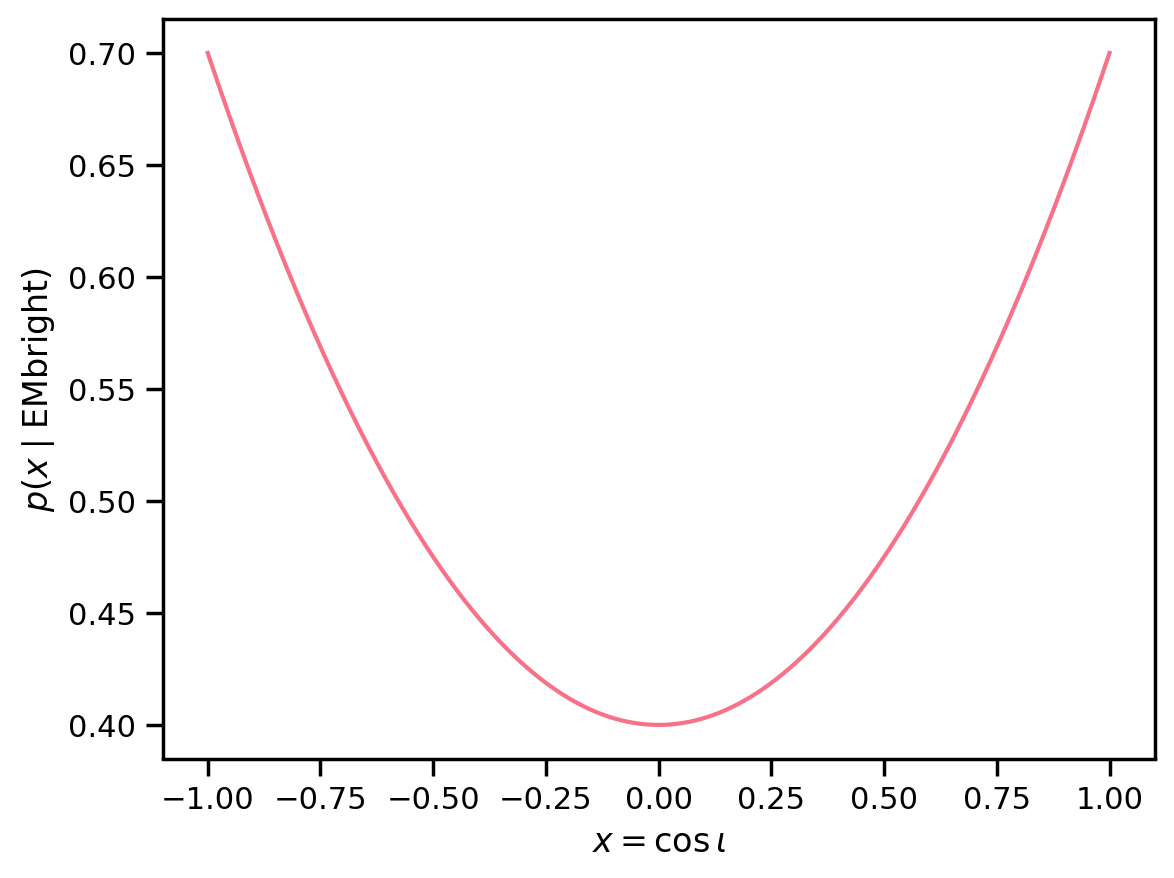

In [57]:
def Pdet_true(x, A):
    return 0.5*(A[0] + A[1]*x + 0.5*A[2]*(3*x*x-1))

A_true = [1.0, 0.0, 0.4]

x = np.linspace(-1, 1, 1024)
plt.plot(x, Pdet_true(x, A_true))
plt.xlabel(r'$x = \cos \iota$')
plt.ylabel(r'$p\left( x \mid \mathrm{EMbright} \right)$')

Can we recover this inclination distribution in a redshift-selected sample, again while learning about the cosmology?

In [25]:
N = 128

fl = 1.0
fr = 1.0

x = np.linspace(-1, 1, 1024)
px = Pdet_true(x, A_true)
cx = si.cumtrapz(px, x, initial=0)
xs_true = np.interp(np.random.uniform(low=0, high=cx[-1], size=N), cx, x)

h_true = 0.7
dmax = 4/5
ds_true = dmax*np.cbrt(np.random.uniform(low=0, high=1, size=N))
zmax = dmax*h_true
zs_true = ds_true*h_true

Ar_true = fr*np.square(1+xs_true)/ds_true
Al_true = fl*np.square(1-xs_true)/ds_true

Ar = np.random.normal(loc=Ar_true, scale=1)
Al = np.random.normal(loc=Al_true, scale=1)

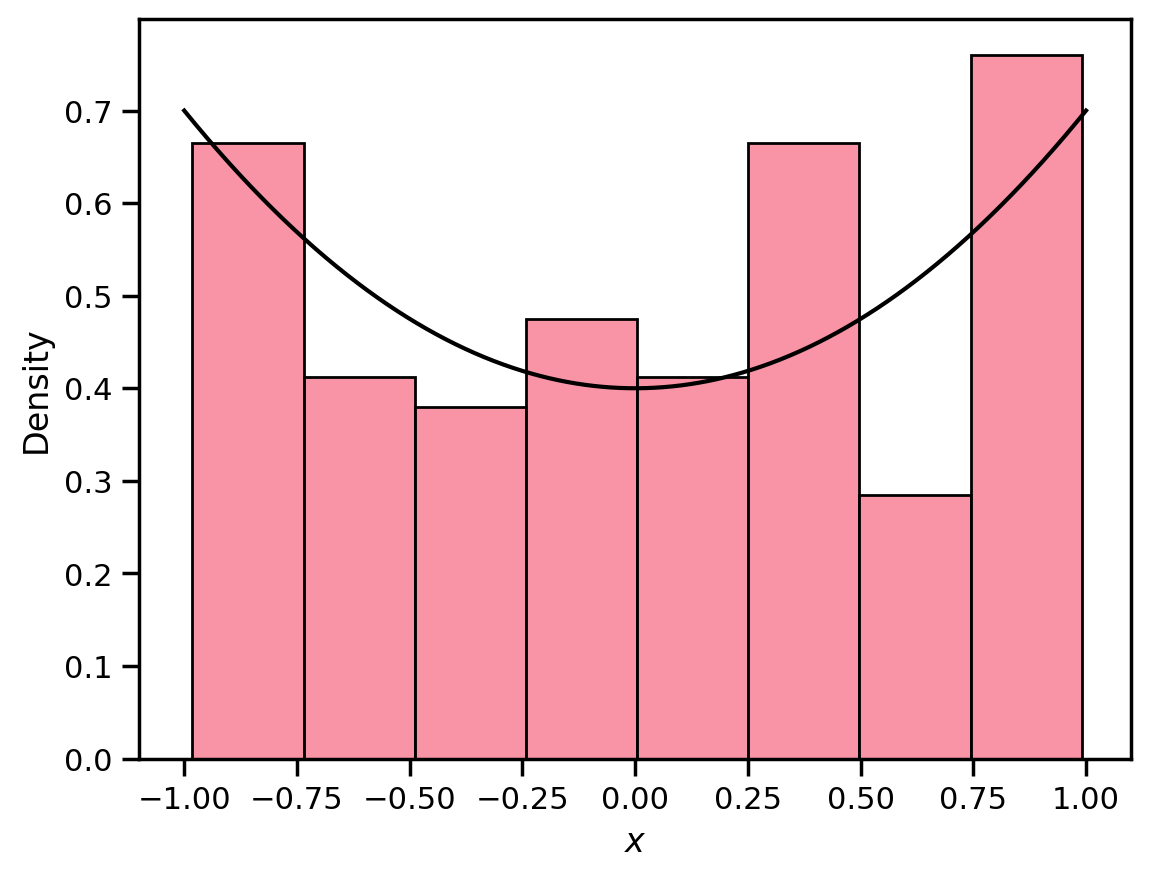

In [26]:
sns.histplot(xs_true, stat='density')
plt.xlabel(r'$x$')
plt.plot(x, Pdet_true(x, A_true), color='k')

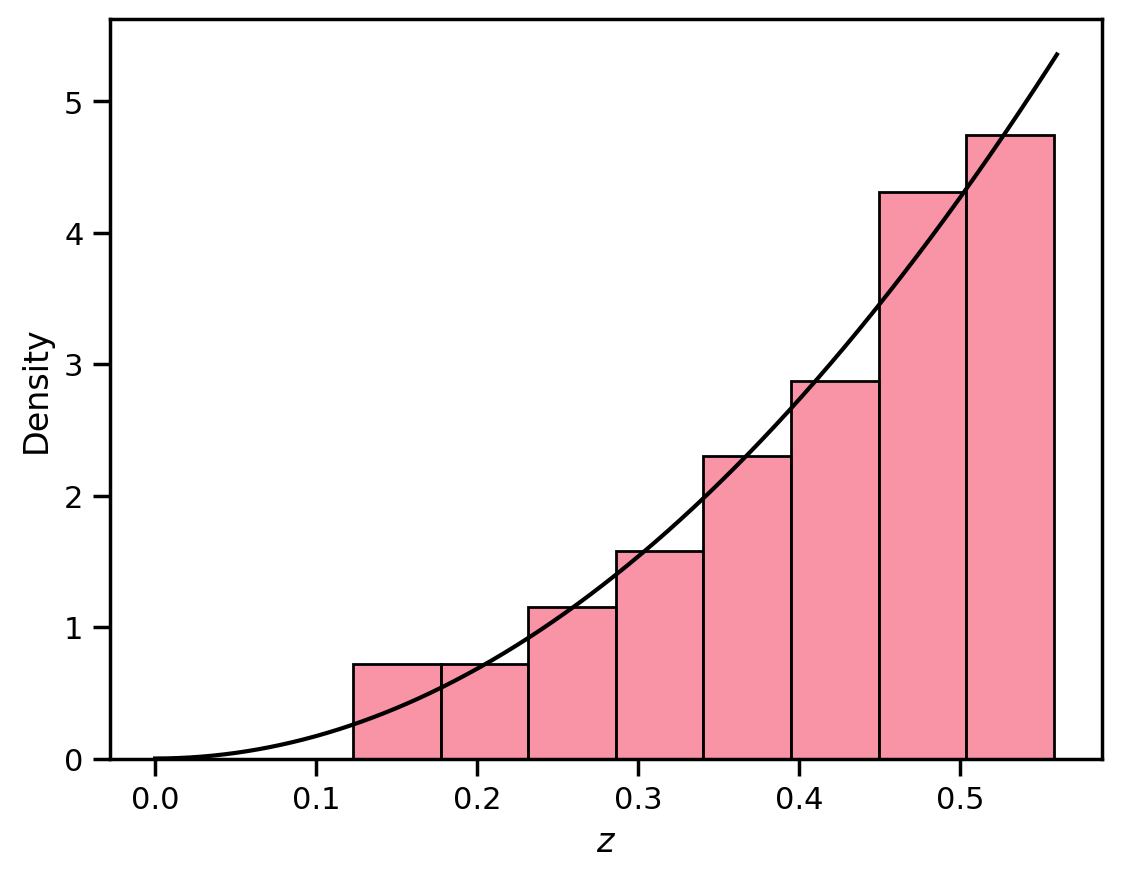

In [27]:
sns.histplot(zs_true, stat='density')
plt.xlabel(r'$z$')
z = np.linspace(0, zmax, 1024)
plt.plot(z, 3*z*z/(zmax*zmax*zmax), color='k')

Here is the distribution of SNRs---if anything, we are being a bit pessisimistic about how well distances can be measured.

Text(0.5, 0, '$\\rho = \\sqrt{\\frac{A_L^2 + A_R^2}{2}}$')

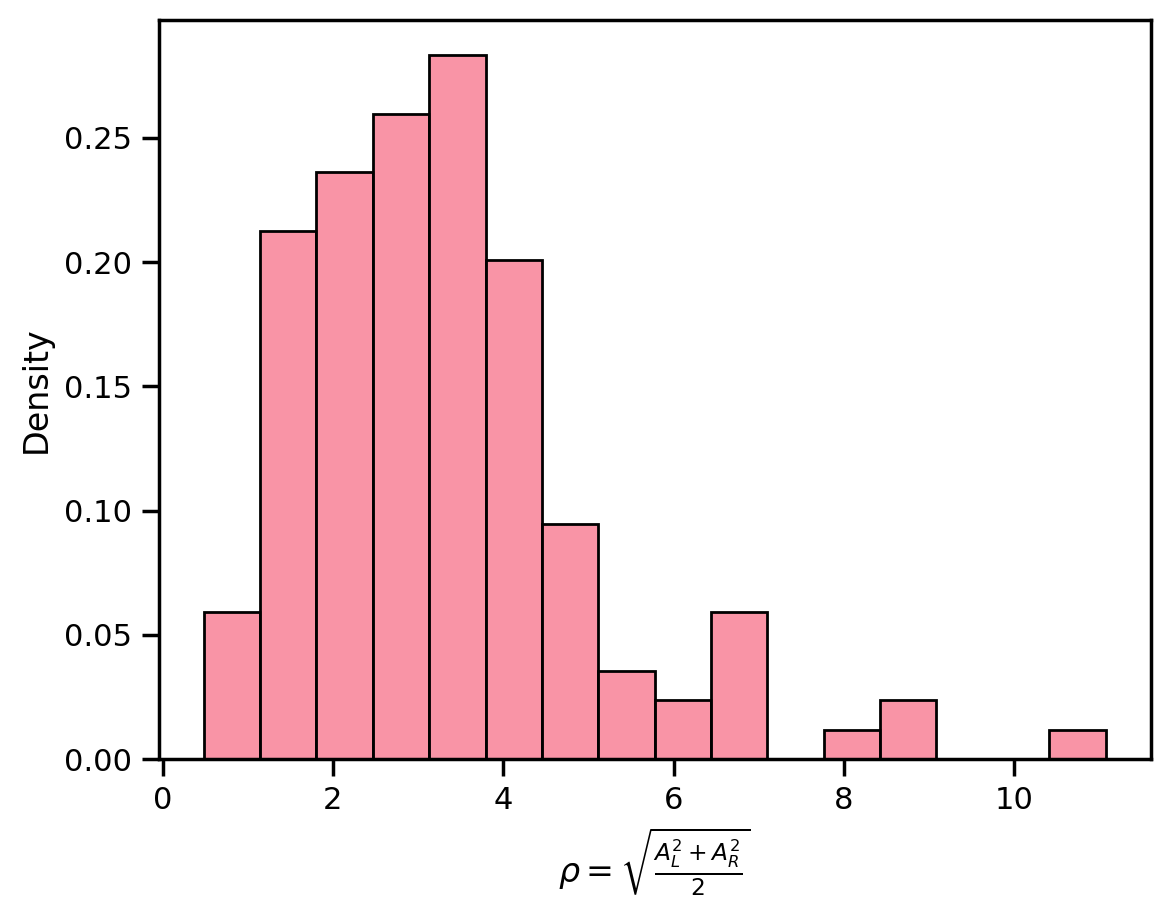

In [55]:
sns.histplot(np.sqrt((Al*Al + Ar*Ar)/2), stat='density')
plt.xlabel(r'$\rho = \sqrt{\frac{A_L^2 + A_R^2}{2}}$')

In [42]:
event_index = np.arange(N)
with pm.Model(coords={'event_index': event_index}) as model:
    h = pm.Uniform('h', lower=0.35, upper=1.4)

    A0 = 1.0
    A1 = pm.Uniform('A1', lower=-1/2, upper=1/2)
    A2 = pm.Uniform('A2', lower=-1/2, upper=1/2)

    x = pm.Uniform('x', lower=-1, upper=1, dims='event_index')
    _ = pm.Potential('x_prior', at.sum(at.log(Pdet_true(x, [A0, A1, A2]))))

    d = pm.Deterministic('d', zs_true/h, dims='event_index')

    _ = pm.Normal('Ar', mu=fr*at.square(1 + x)/d, sigma=1, observed=Ar, dims='event_index')
    _ = pm.Normal('Al', mu=fl*at.square(1 - x)/d, sigma=1, observed=Al, dims='event_index')

In [43]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [h, A1, A2, x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.


array([[<AxesSubplot: title={'center': 'h'}>,
        <AxesSubplot: title={'center': 'h'}>],
       [<AxesSubplot: title={'center': 'A1'}>,
        <AxesSubplot: title={'center': 'A1'}>],
       [<AxesSubplot: title={'center': 'A2'}>,
        <AxesSubplot: title={'center': 'A2'}>],
       [<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'd'}>,
        <AxesSubplot: title={'center': 'd'}>]], dtype=object)

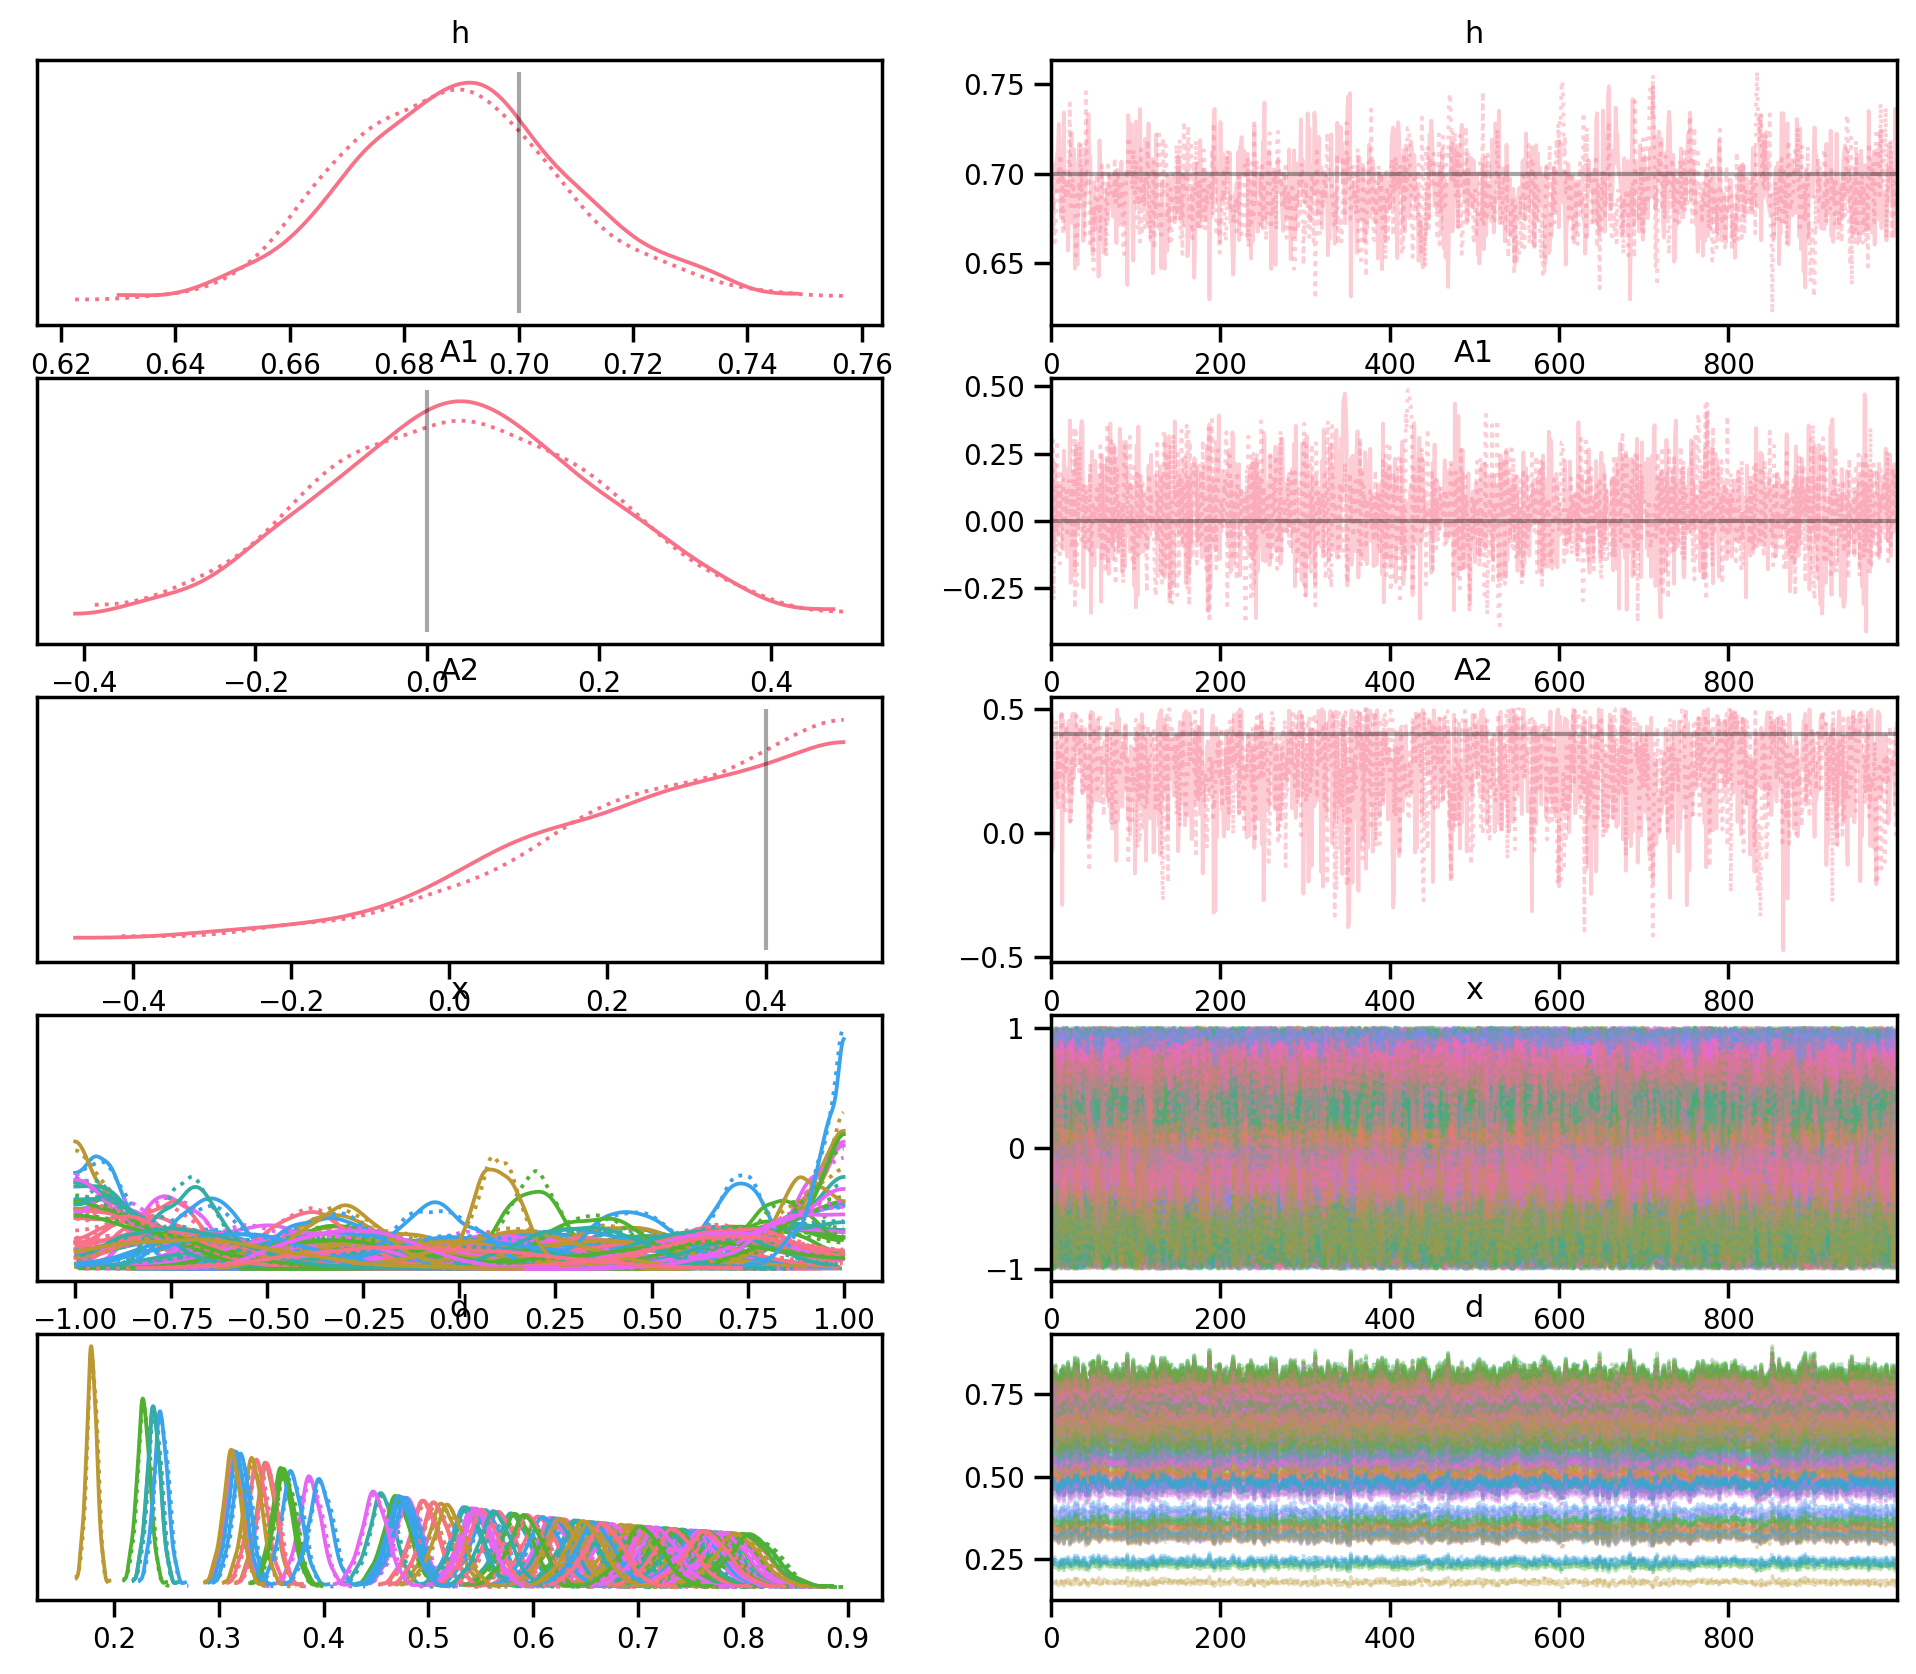

In [44]:
az.plot_trace(trace, lines=[('h', {}, h_true), ('A1', {}, A_true[1]), ('A2', {}, A_true[2])])

Text(0, 0.5, '$P_\\mathrm{det}(x)$')

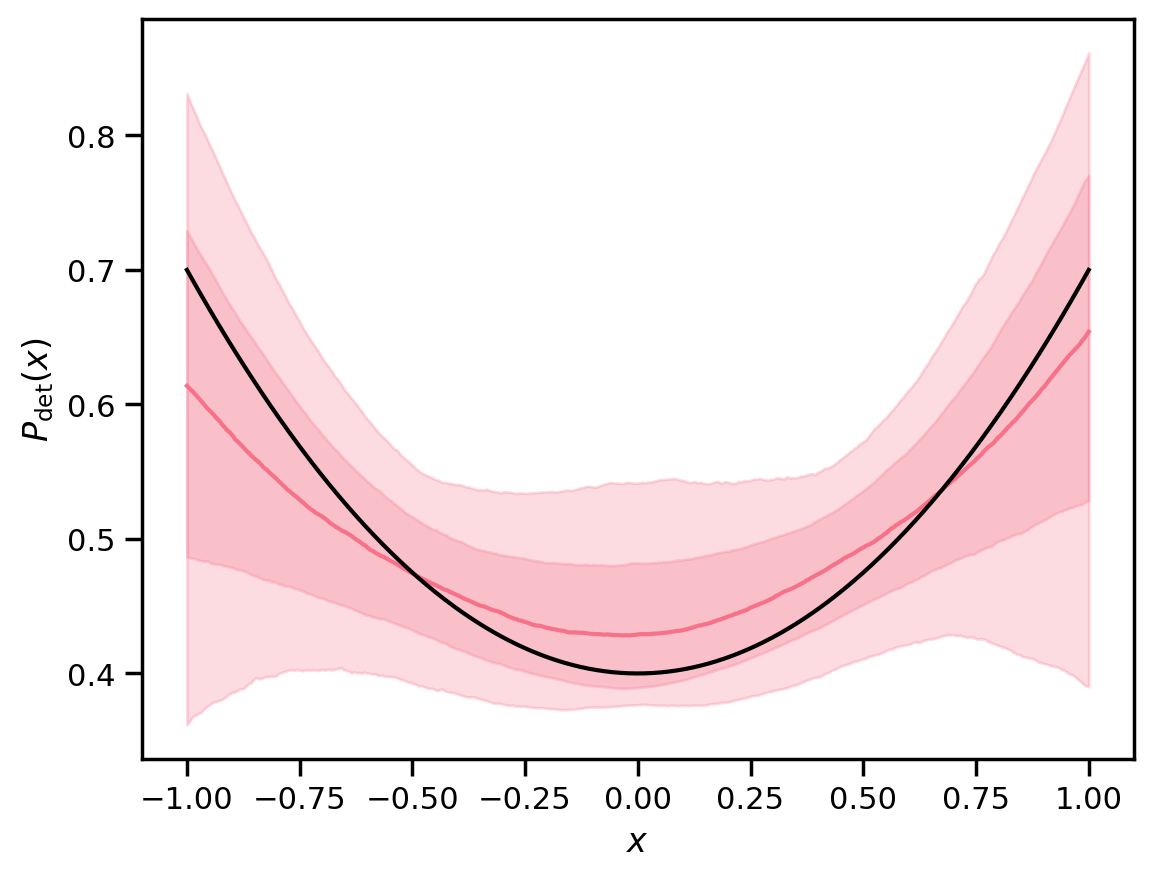

In [51]:
x = xr.DataArray(np.linspace(-1, 1, 1024), coords={'x_index': np.arange(1024)}, dims='x_index')
px = Pdet_true(x, [1.0, trace.posterior.A1, trace.posterior.A2])
l, = plt.plot(x, px.median(dim=['chain', 'draw']))
plt.fill_between(x, px.quantile(0.84, dim=['chain', 'draw']), px.quantile(0.16, dim=['chain', 'draw']), color=l.get_color(), alpha=0.25)
plt.fill_between(x, px.quantile(0.975, dim=['chain', 'draw']), px.quantile(0.025, dim=['chain', 'draw']), color=l.get_color(), alpha=0.25)
plt.plot(x, Pdet_true(x, A_true), color='k')
plt.xlabel(r'$x$')
plt.ylabel(r'$P_\mathrm{det}(x)$')

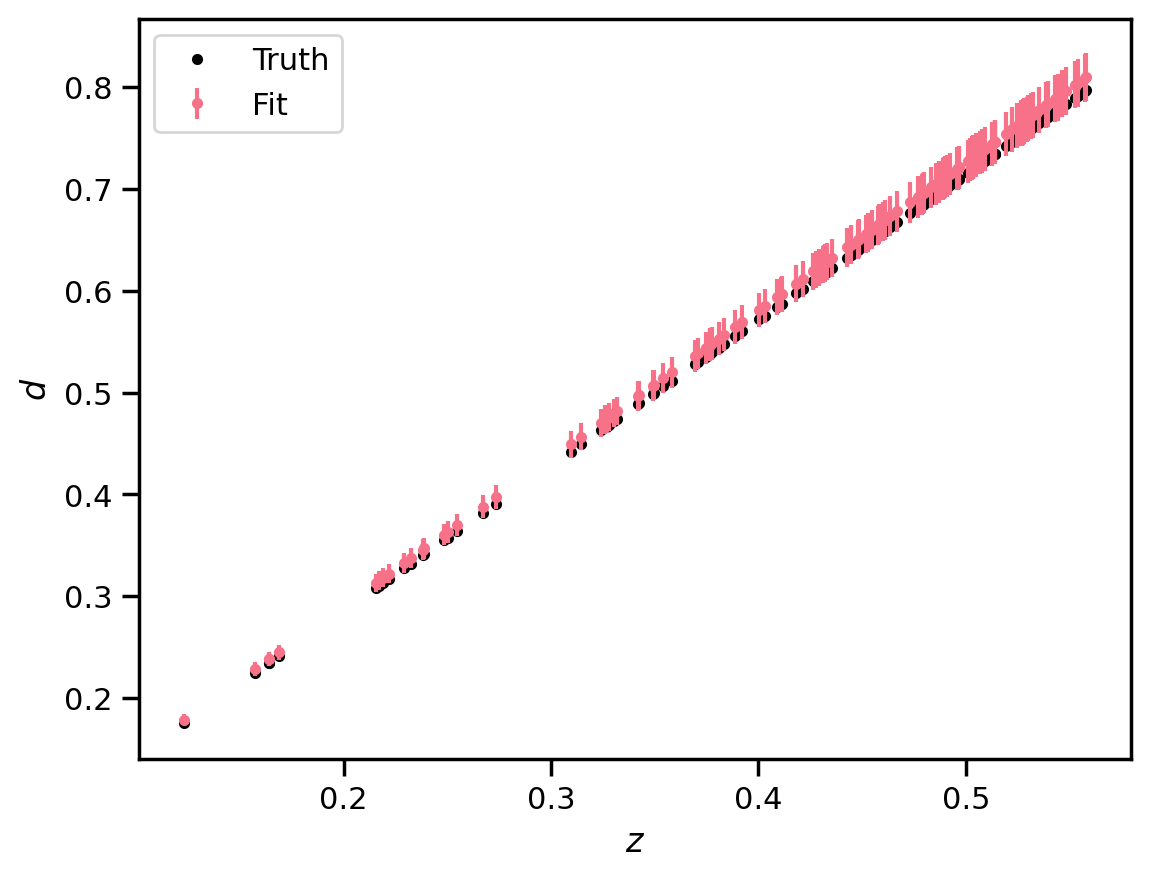

In [58]:
plt.plot(zs_true, ds_true, '.k', label='Truth')
plt.errorbar(zs_true, trace.posterior.d.mean(dim=['chain', 'draw']), trace.posterior.d.std(dim=['chain', 'draw']), fmt='.', label='Fit')
plt.xlabel(r'$z$')
plt.ylabel(r'$d$')
plt.legend()